In [1]:
import os
import numpy as np
import h5py
import matplotlib.pylab as plt
from scipy.io import savemat, loadmat
import sparse

project_path = "../"
data_path = os.path.join(project_path, "Data/raw_data")

## load raw data of WBM and preprocess

raw_data shape: (800, 171508)
0th coordinate: min -66.0, max 63.0
1th coordinate: min -105.0, max 72.0
2th coordinate: min -45.0, max 81.0


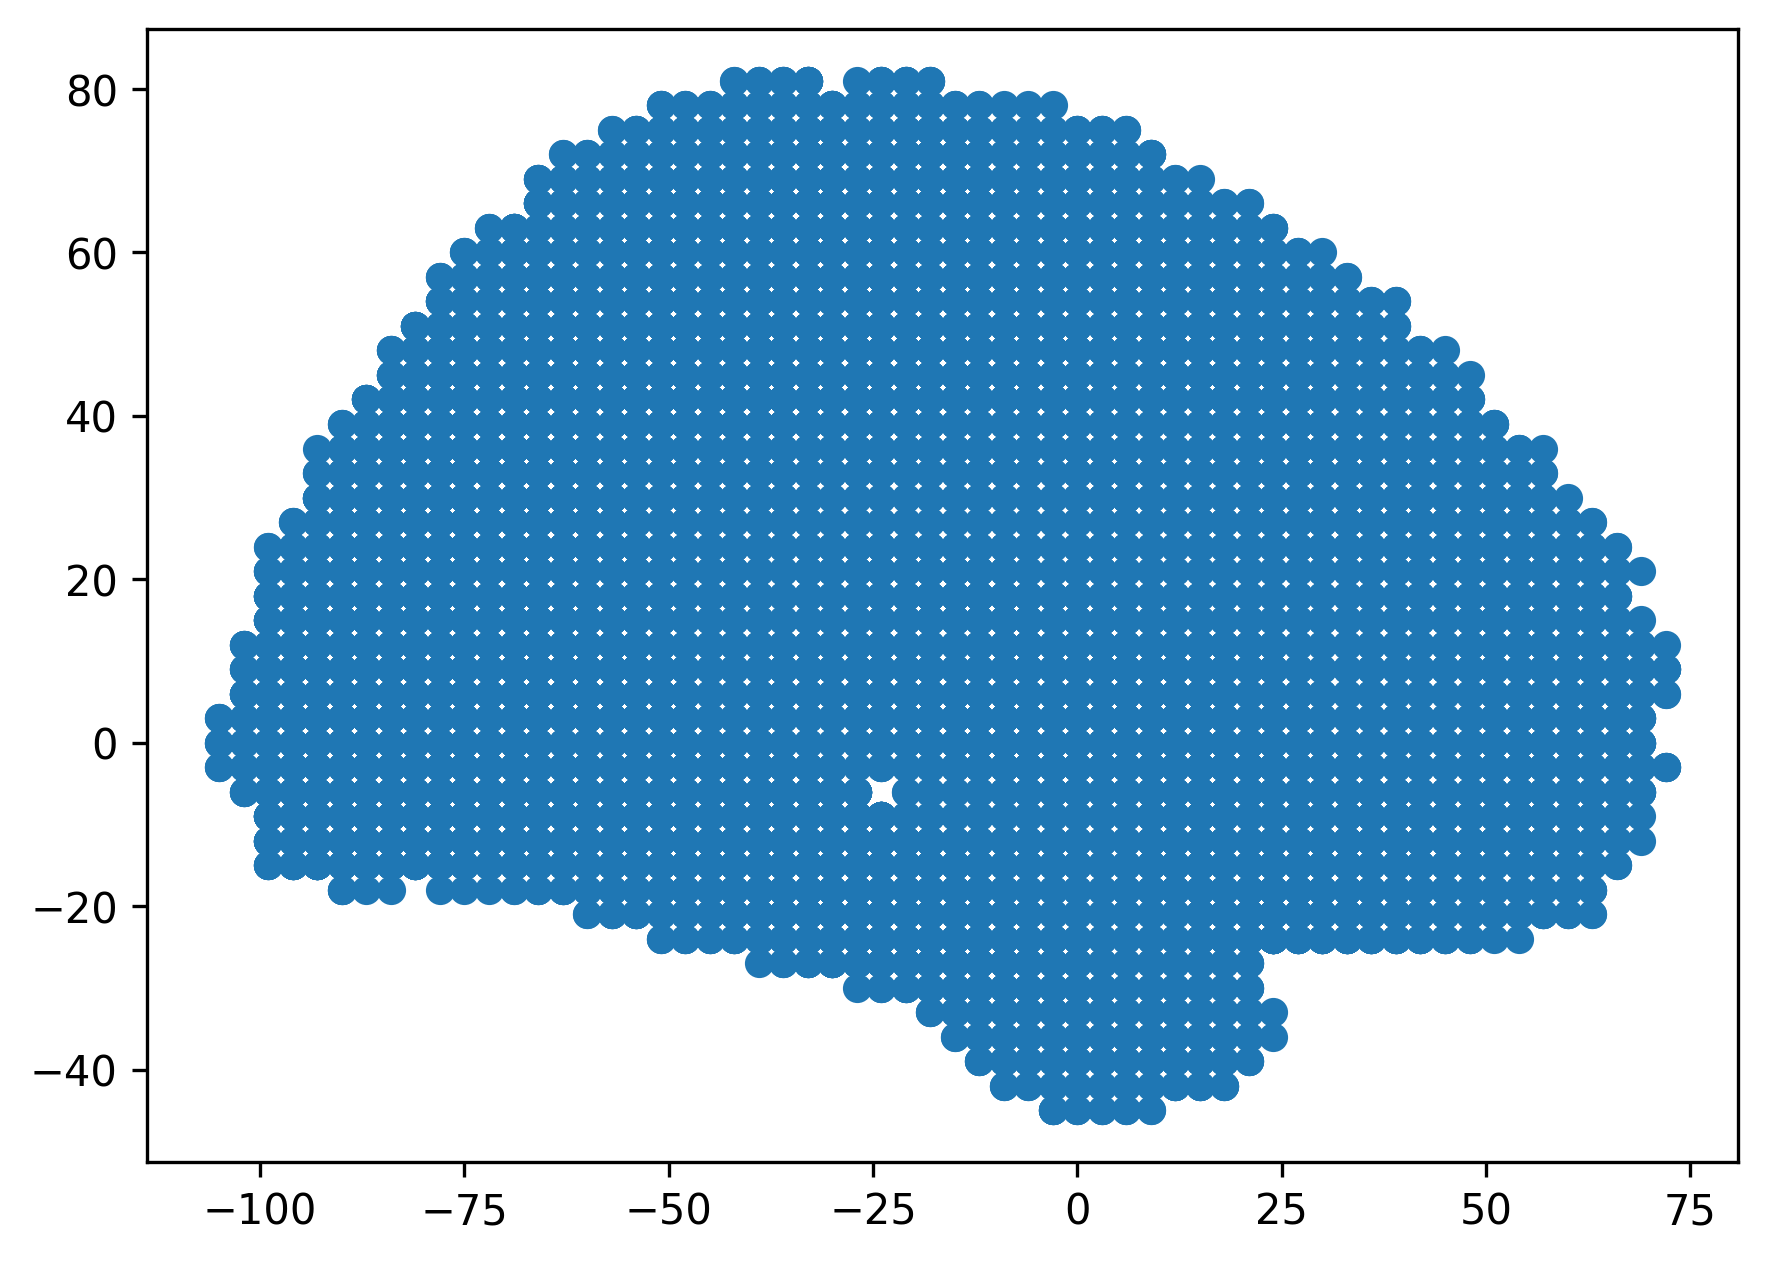

In [2]:
freqs = np.load("../Data/raw_data/fr800_wbm_raw_data.npy")
print(f"raw_data shape: {freqs.shape}")
blk_size = np.load("../Data/raw_data/blk_size_wbm_raw_data.npy")
path = os.path.join(data_path, "DTI_voxel_network.mat")
xyz = h5py.File(path, "r")["dti_xyz2"][:]
coordinate_min = np.empty(3, dtype=np.int64)
coordinate_max = np.empty(3, dtype=np.int64)
for i in range(xyz.shape[1]):
    print(f"{i}th coordinate: min {xyz[:, i].min()}, max {xyz[:, i].max()}")
    coordinate_min[i] = xyz[:, i].min()
    coordinate_max[i] = xyz[:, i].max()
fig = plt.figure(figsize=(8, 5), dpi=300)
plt.scatter(xyz[:, 1], xyz[:, 2])
fig.gca().set_aspect(1)
plt.show()

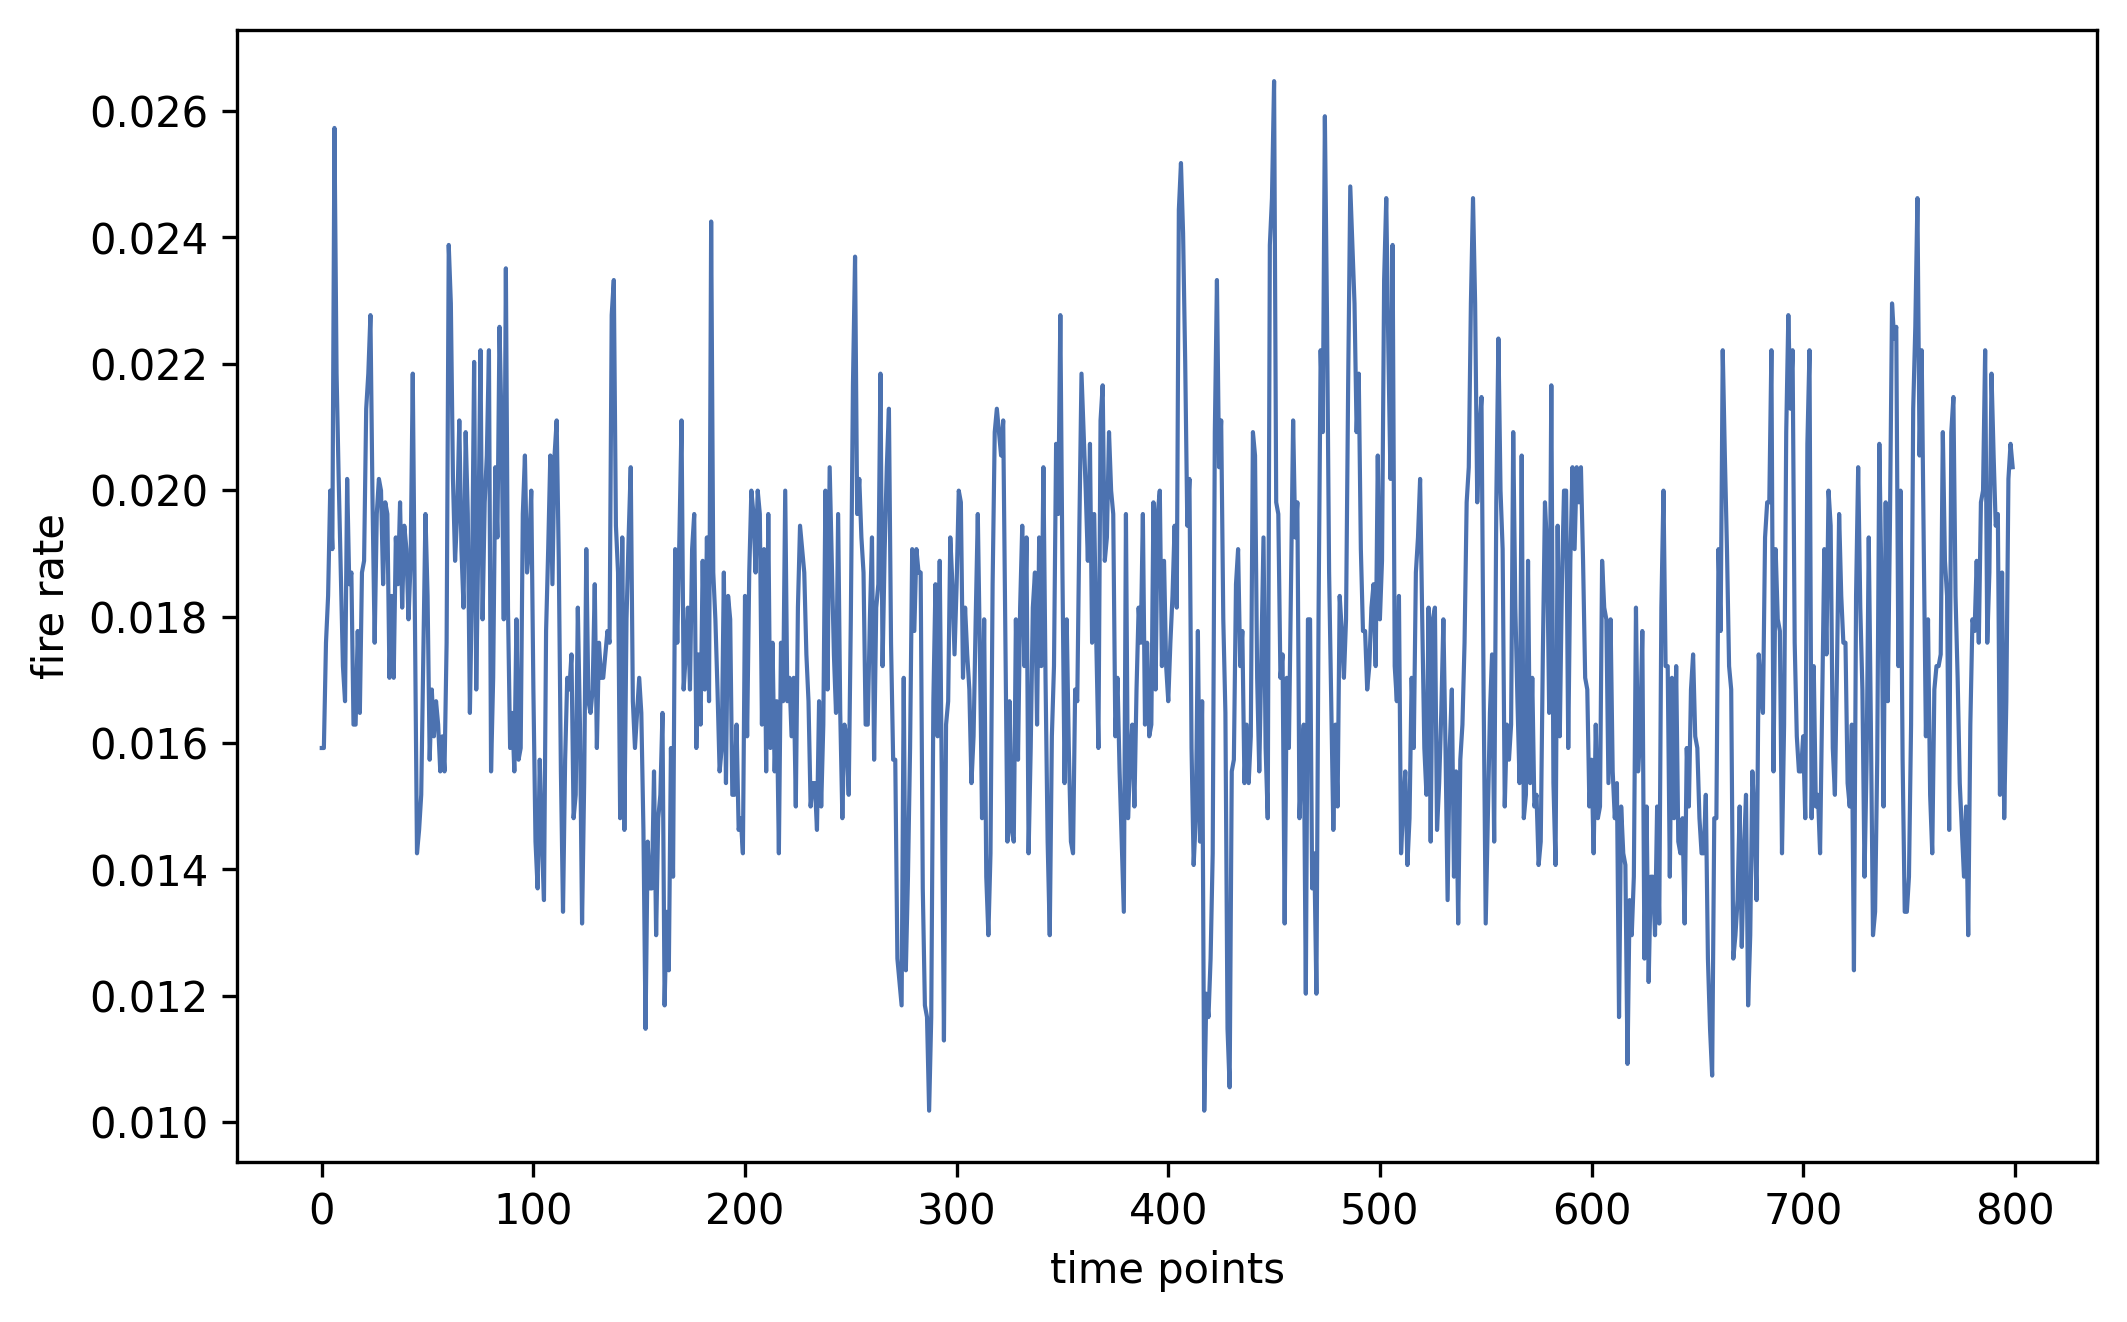

In [3]:
conn_inform = h5py.File(path, 'r')
aal_index = conn_inform['dti_AAL_lgn'][()]
aal_index = aal_index.astype(np.int32).reshape(-1) - 1
assert aal_index.min() == 0 and aal_index.max() == 91
subcortical = np.array([37, 38, 41, 42, 71, 72, 73, 74, 75, 76, 77, 78], dtype=np.int32) - 1
subcortical_index = [i for i in range(len(aal_index)) if aal_index[i] in subcortical]
cortical_idnex = [i for i in range(len(aal_index)) if i not in subcortical_index]
divide_point = len(cortical_idnex)
index = np.concatenate([np.array(cortical_idnex, dtype=np.int32), np.array(subcortical_index, dtype=np.int32)],
                       axis=0)
temp = np.argsort(index)
inver_index = np.arange(len(aal_index))[temp]

t = freqs.shape[0]
cortical_fr = freqs[:, :divide_point * 8].reshape((-1, divide_point, 8)).sum(axis=-1) / blk_size[
                                                                                        :divide_point * 8].reshape(
    (divide_point, 8)).sum(axis=-1)
subcortical_fr = freqs[:, divide_point * 8:].reshape((t, -1, 2)).sum(axis=-1) / blk_size[divide_point * 8:].reshape(
    (-1, 2)).sum(axis=-1)
fr = np.concatenate([cortical_fr, subcortical_fr], axis=1)
assert fr.shape[1] == len(inver_index)
fr = fr[:, inver_index]
myblue = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
fig = plt.figure(figsize=(8,5), dpi=300)
fig.gca().plot(fr[:, 33], lw=1, c=myblue)
fig.gca().set_xlabel("time points")
fig.gca().set_ylabel("fire rate")
plt.show()

In [4]:
# reduce tiem length 800 to 200.
fr = fr[400:600, :]
t = fr.shape[0]
xyz_new = np.ceil(xyz / 2).astype(np.int64)
xyz_new = xyz_new + np.array([33, 52, 22])
for i in range(xyz_new.shape[1]):
    print(f"{i}th coordinate: min {xyz_new[:, i].min()}, max {xyz_new[:, i].max()}")
    coordinate_min[i] = xyz_new[:, i].min()
    coordinate_max[i] = xyz_new[:, i].max()
xyz_new = xyz_new.astype(np.int64).T  # (3, 22703)
shape = [coordinate_max[0] + 1, coordinate_max[1] + 1, coordinate_max[2] + 1, t]
coords = np.empty([4, fr.shape[1] * fr.shape[0]], dtype=np.int64)
coords[(0, 1, 2), :] = np.broadcast_to(xyz_new[:, :, None], (xyz_new.shape[0], xyz_new.shape[1], t)).reshape(
    (3, -1))
coords[3, :] = np.broadcast_to(np.arange(t, dtype=np.int64), (fr.shape[1], t)).reshape(-1)
data = fr.T.reshape(-1)
fr800_with_coordinate_sparse = sparse.COO(coords=coords, data=data, shape=shape)
# sparse.save_npz(os.path.join(data_path, "fr800_with_coordinate_sparse.npz"), fr800_with_coordinate_sparse)

0th coordinate: min 0, max 65
1th coordinate: min 0, max 88
2th coordinate: min 0, max 63


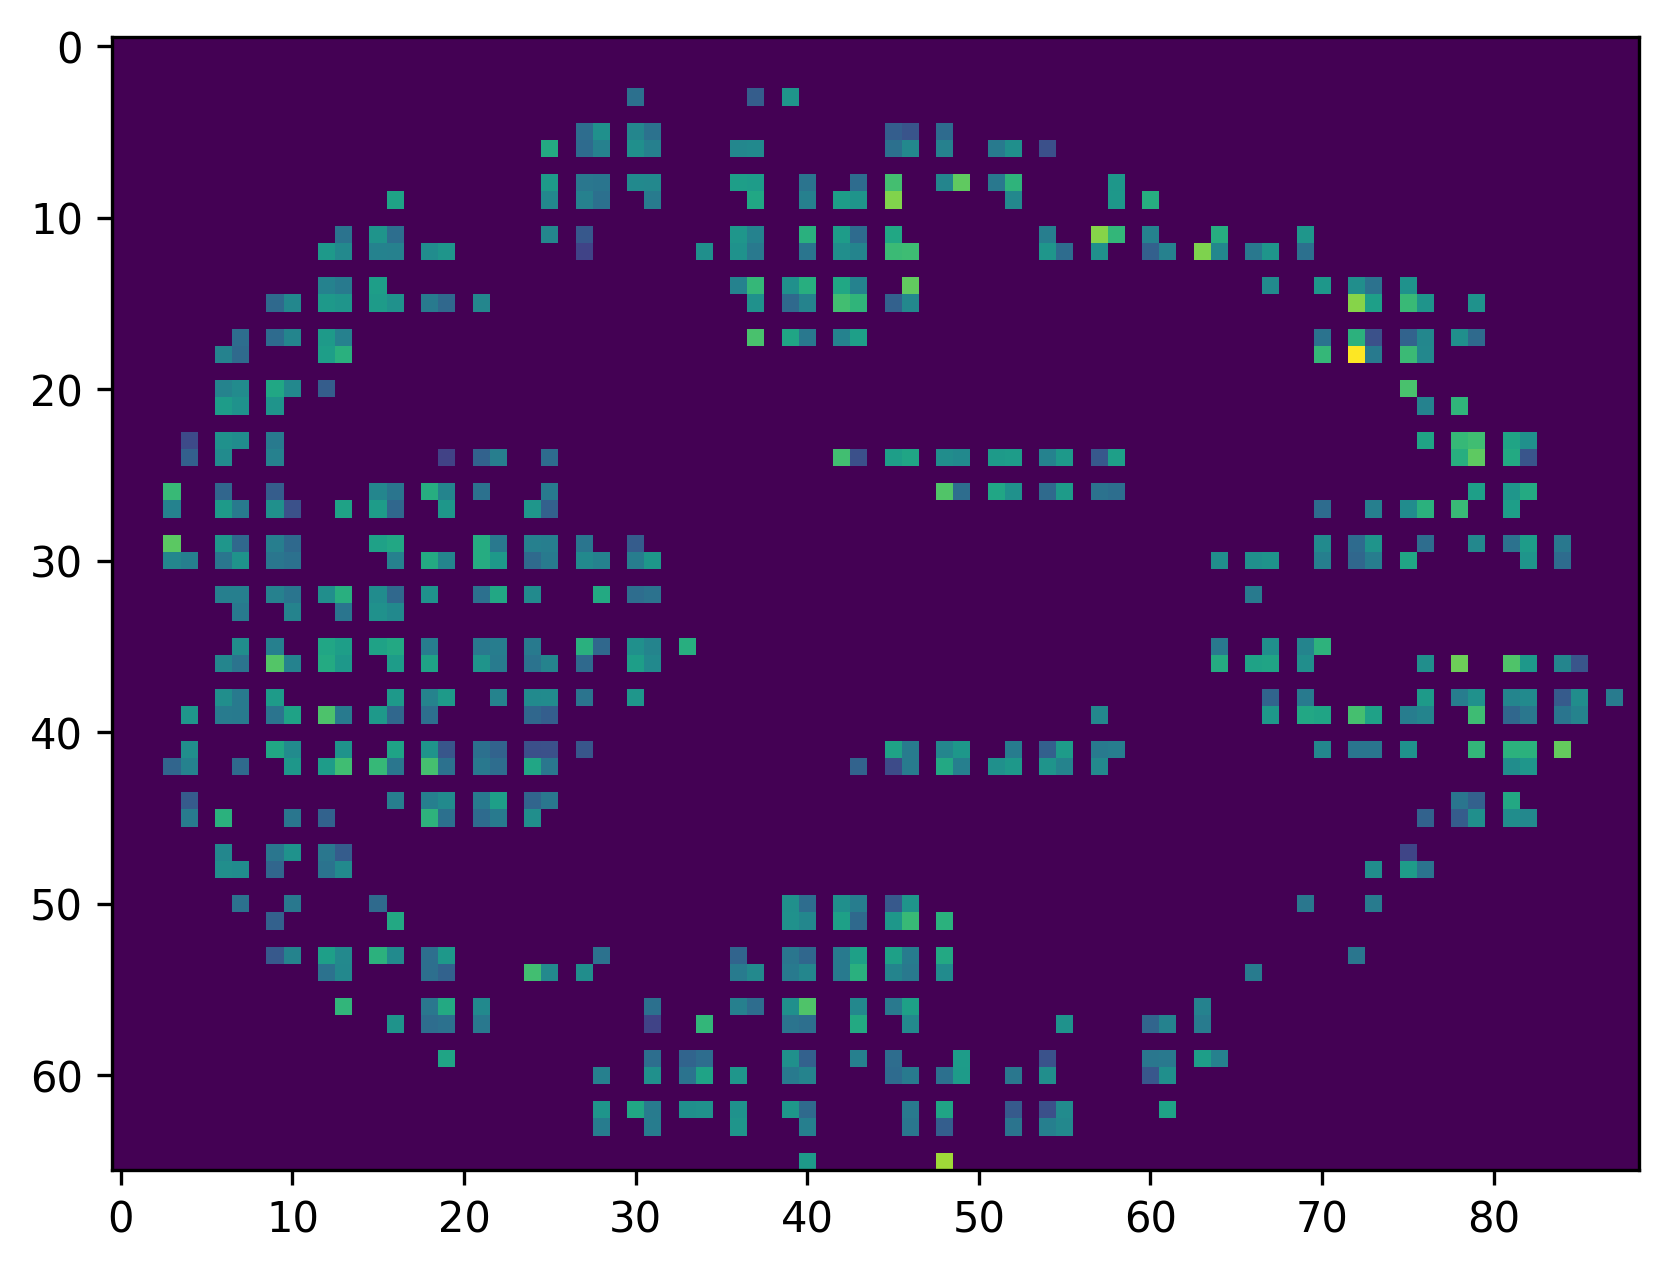

In [6]:
fr800_with_coordinate = fr800_with_coordinate_sparse.todense()
savemat(os.path.join(data_path, "fr800_with_coordinate.mat"), mdict={"brain_image":fr800_with_coordinate})
print(f"fr800_with_coordinate shape: {fr800_with_coordinate.shape}")
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.gca().imshow(fr800_with_coordinate[:,:, 33, 20])
plt.show()

## interpolate by using mdian value interpolate by matlab

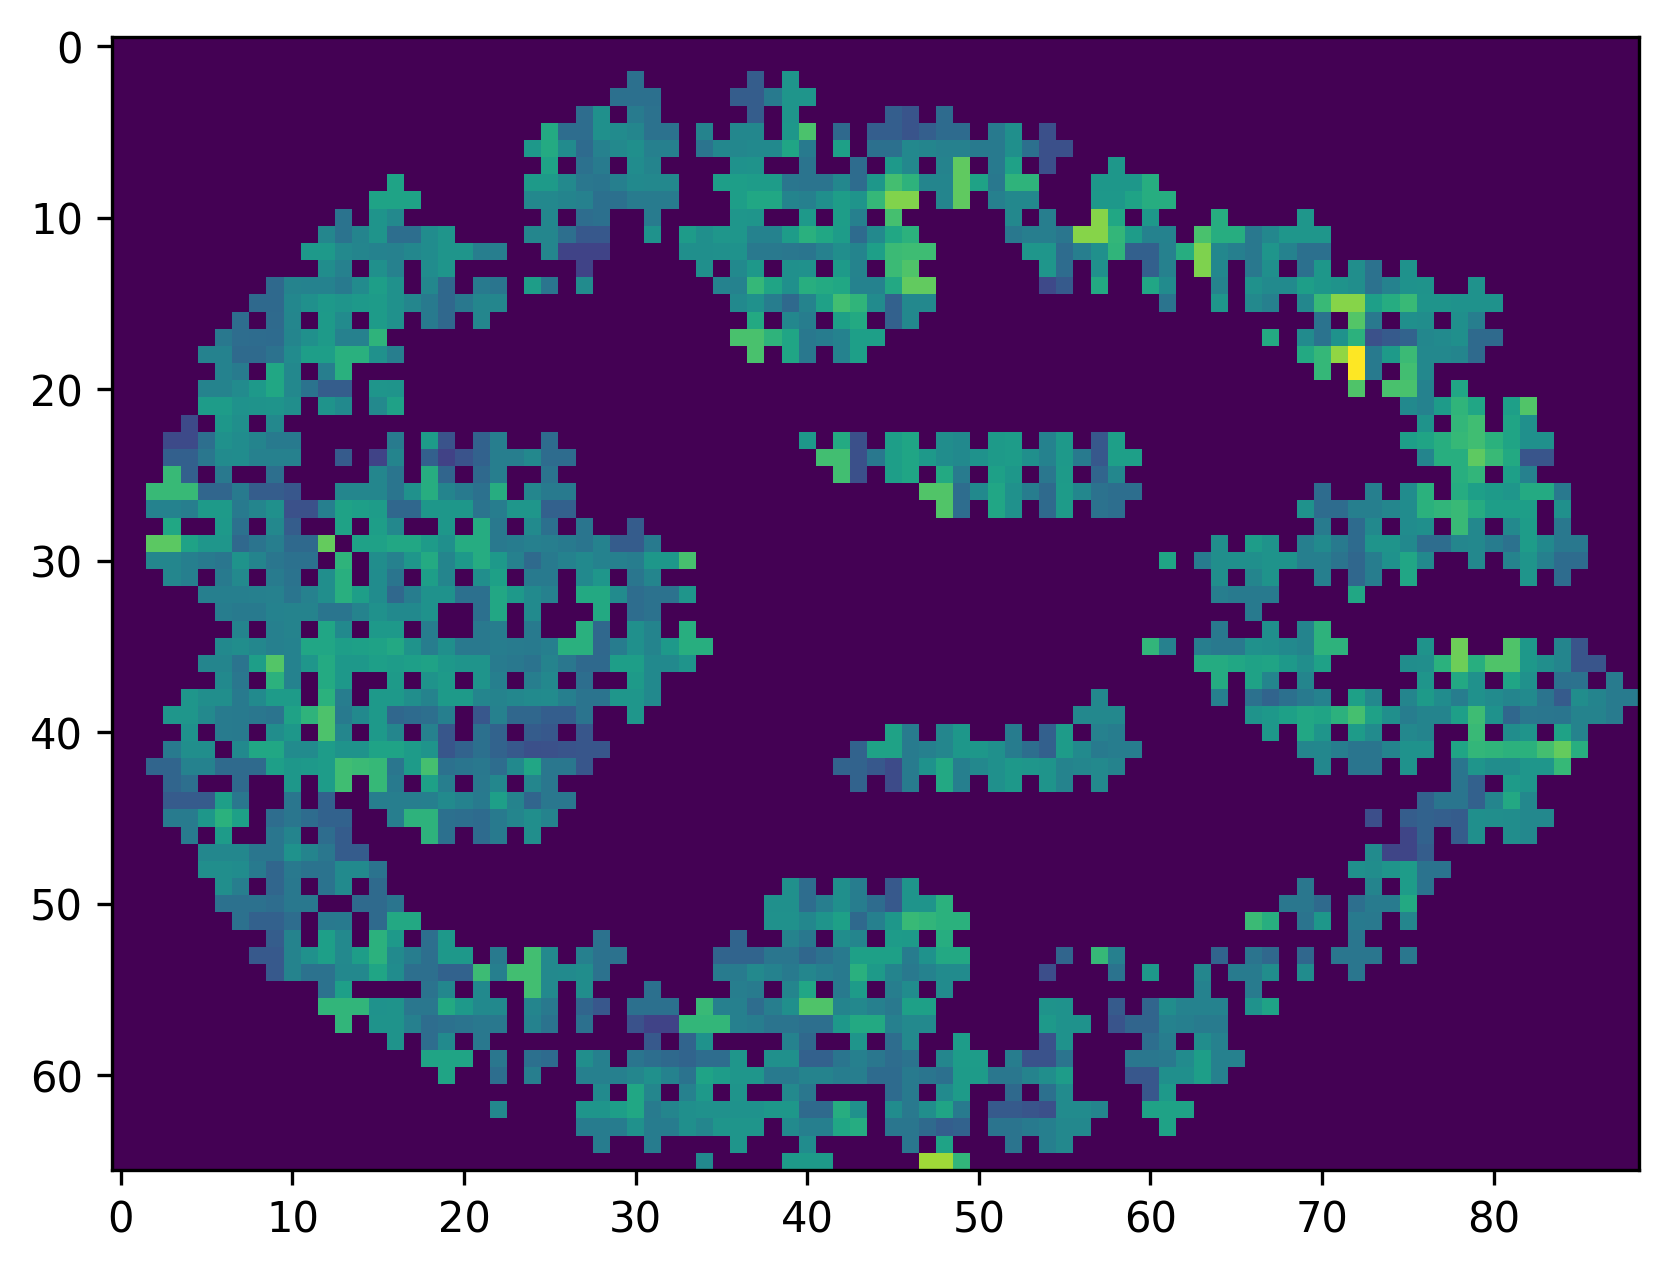

In [6]:
# "../matlab/main_interpolate.m"
fr800_with_coordinate_interpolate = loadmat(os.path.join(data_path, "fr_800_with_coordinate_interpolated.mat"))
fr800_with_coordinate_interpolate.keys()
interpolate_brain_image = fr800_with_coordinate_interpolate["interpolate_brain_image"]
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.gca().imshow(interpolate_brain_image[:,:, 33, 20])
plt.show()

## interpolate by using mdian value interpolate by matlab twice


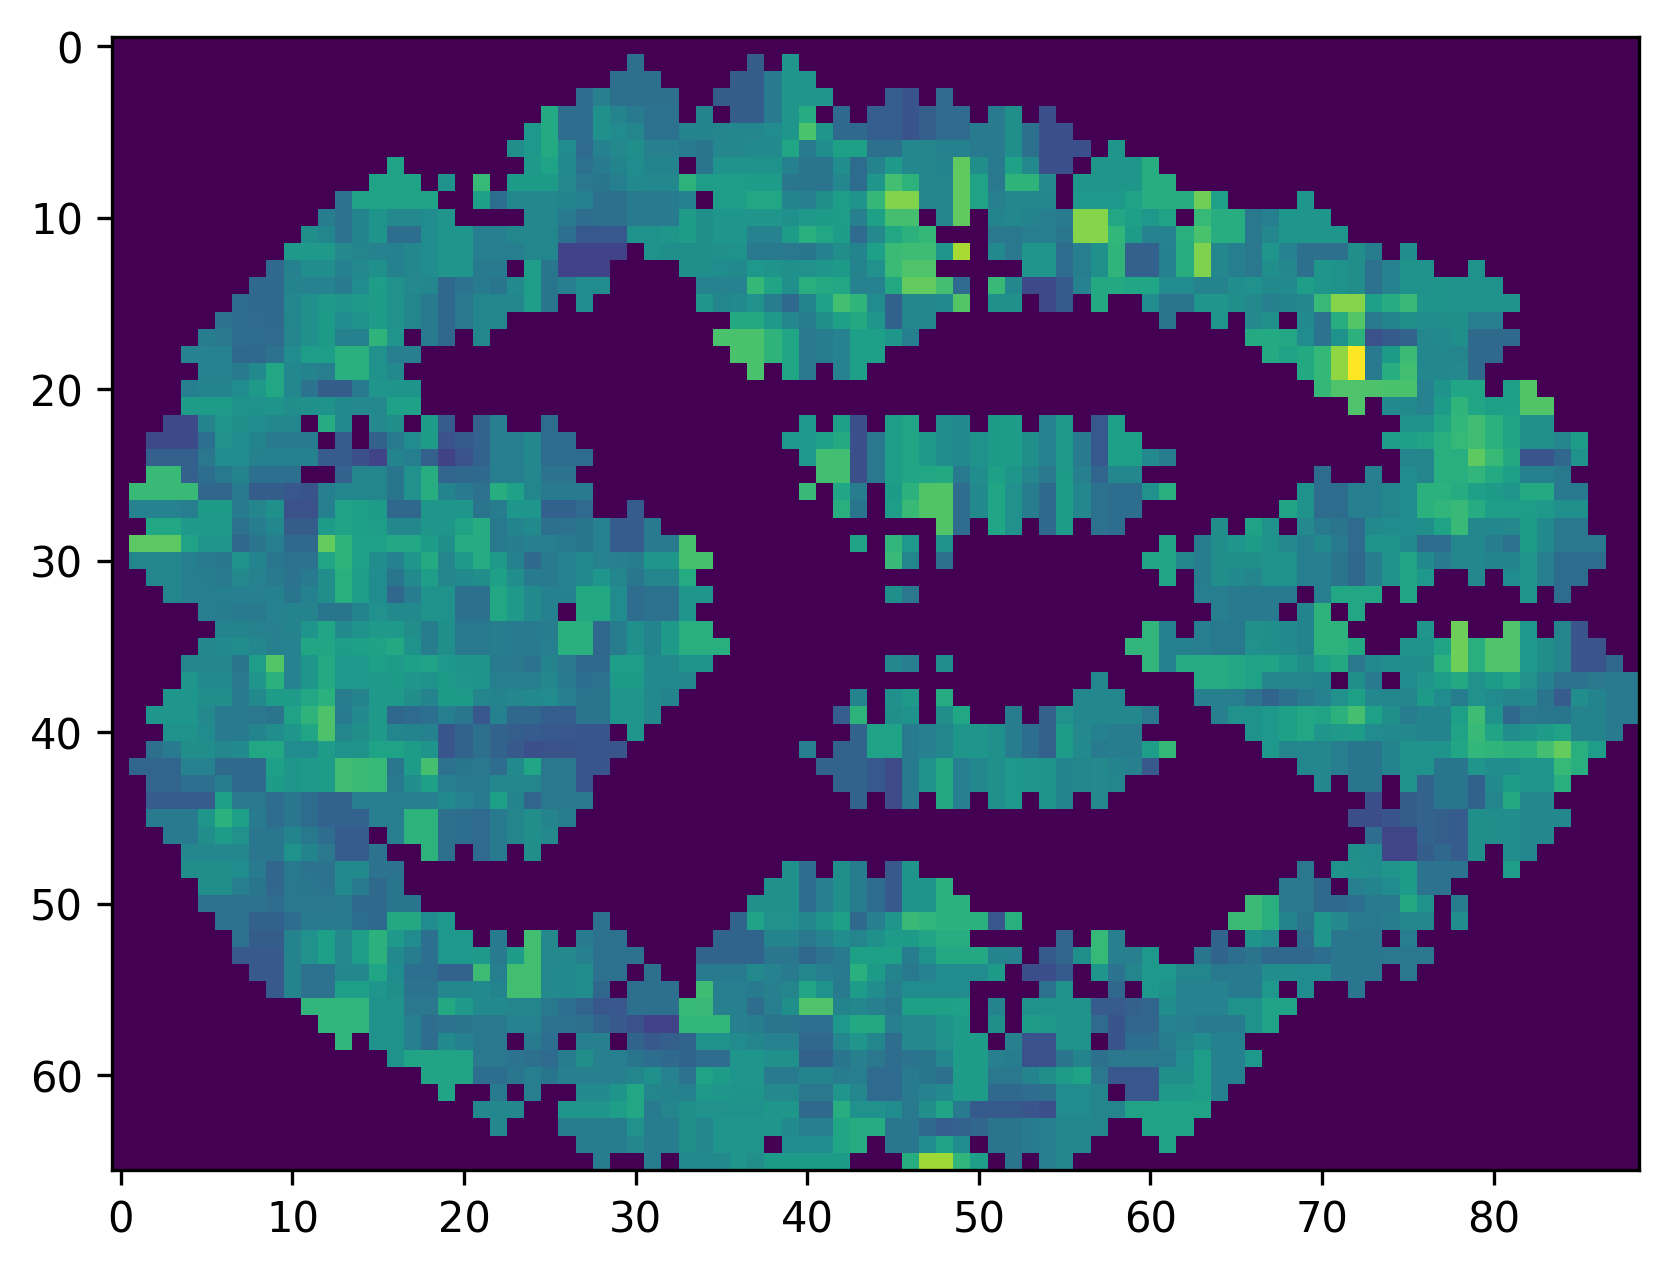

In [3]:
fr800_with_coordinate_interpolate = loadmat(os.path.join(data_path, "fr_800_with_coordinate_interpolated2.mat"))
fr800_with_coordinate_interpolate.keys()
interpolate_brain_image = fr800_with_coordinate_interpolate["interpolate_brain_image2"]
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.gca().imshow(interpolate_brain_image[:,:, 33, 20])
plt.show()

## linear interpolate


In [6]:
from scipy.interpolate import interpn
x = np.arange(shape[0])
y = np.arange(shape[1])
z = np.arange(shape[2])
t = np.arange(shape[3])
points = (x, y, z, t)
values = fr800_with_coordinate_sparse.todense()
xi = np.stack(np.meshgrid(x, y, z, t), axis=-1).reshape((-4, 4))
point = interpn(points, values, xi)
point = point.reshape(shape)
savemat("fr800_with_coordinate_interpolated_new.mat", mdict={"interpolate_brain_image": point})#%%
fig = plt.figure(figsize=(8, 5), dpi=300)
fig.gca().imshow(point[:,:, 33, 20])
plt.show()


TypeError: only integer scalar arrays can be converted to a scalar index